# Notes 

## Research notes

### General notes

* Two regimes in time: annealing, and then settled
* Two regimes in setup: Egalitarian (Free knowledge) and dictator (Centralized knowledge)

---
### Model modification ideas

#### ⬛ **Major idea 1:** Groups have many dimensions

* Groups have the same number of preference dimensions as individuals
* Groups have fewer dimensions than individuals
 * Individuals need to balance their fulfillment with groups? How do they choose?
  * **Choice rule 1:** Individuals focus on the dimension which is furthest from any existing group ("I join this group to fulfill something I can't fulfill alone")
  * **Choice rule 2:** Individuals join multiple groups until all their dimensions are met
* Groups have more dimensions than individuals??
 * The groups' identity changes as the members who make it up change
 * Absent any within-group dynamics, why would this be any different than having separate groups?

#### ⬛ **Major idea 2:** Multiple group membership

* Individuals must join X groups, where X > 1
* Individuals join as many groups as fulfills them. This may need to involve some counterbalancing mechanic where individuals suffer a penalty for joining too many groups
 * Fulfillment : closest for each dimension
 * Fulfillment : closets for important dimensions

#### ⬛ **Major idea 3:** Groups splitting and joining

Easier goal would be to set up the rules explicitly and see how individual choices affects group ecology. 

* Encoding rules for groups splitting and fusing explicitly
  * Splitting because of size (i.e. group > 300 so it splits)
  * Splitting because of difference? (i.e. group's distribution has two modes, so it splits)
  * Splitting because of an optimization parameter (i.e. if a subset of the group would have decreased dissimilarity, it splits)

Harder goal would be to set up rules such that groups split and join dynamically. 

* Create set of rules that defines the substance/scope of group identity, and less about parsing out "least bad alternatives"

#### ⬛ **Major idea 4:** Bounded confidence

* Bounded confidence? Overlapping latitudes of acceptance/rejection? Ideas from discussion with Harry, terms from Jiin
 * Various inspirations from polarization psych analogous to network stuff

---

#### Other ideas

* Pure random model
* Let group hold its value before dying, from Jordan and Ismael. 
 * PROS: Gets at a sense of 'history'
 * CONS: It may not contribute to novel community growth?
* Heterogeneous accessibility / central media
 * Try to replicate the crash-and-burn dynamics of a central group actor
* Individuals are in a network (what would this mean?), or groups are in a network (what would this mean?)
* Mean voting for groups. Other mechanics/functions for group's preference value
* Circular preference dimension
* Write out the abstract/mathy form of this model. Function for choice, function for group aggregation of value 

### Model checks

* Test if it matters that individual values are discrete or continuous. Int vs float

#### Tossed

* Initialize with "closest group", from Sabina. Now with the model fixed, this will likely just be immediately stable. (DONE)

-----

### General dataset comparison ideas

* Crash-and-burn dynamics of platform chasing
* Within-person group changing dynamics
* Catching an ‘invisible exodus’ of people from one subreddit, and checking if they move to another subreddit? If the other sub survives?


### Specific dataset comparison ideas

* Take the times between group-switching for a particular person. Compare them to the times between subreddit-switching posting for a particular person? (Here posts==time)

--- 

# Setup functions

## Class definition

This should try its best to separate the following:
* Editing individual's relationships to groups
* Groups updating their values
* Any effects on public information



Class-version where you extend the graph class to include the individual function and group function. Good for instantiating many versions of the simulation. 

## Universal Functions

In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import functools

In [3]:
def doNothing(): #For debugging purposes when a function needs to be passed in
  pass

clamp = lambda n, minn, maxn: max(min(maxn, n), minn)

def grabMeans(netw,grouplist):
  return {i: netw.nodes[i]['mean'] for i in grouplist}

def grabGroupsize(netw,grouplist):
  return {group: len(list(netw.neighbors(group))) for group in grouplist}

def distMatrix1D(m): #Coded this up quickly because I'm too lazy to import scipy
  m = np.array(m)
  dist = np.tile(m,(len(m),1))
  return np.abs(dist - dist.T)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
class GroupshiftSim():
    
#===============================================================================
# Intializing
#===============================================================================

  def __init__(self, groupshift_function, indivchoice_function, lowvalence = 0, highvalence =100, s = 1, inittype='random'):
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.s = s

    self.savemeans = []
    self.savesizes = []

    self.groupShift = groupshift_function
    self.indivChoice = indivchoice_function
    #Valence range?
    #Valence dimensions?
    #Toroid?
    #Resettype?
    if inittype not in ['random', 'sorted']:
      raise Exception("Invalid type of graph connectivity initialization for this groupshift simulation.")

  def initializeNodes(self, num_nodes, num_groups, inittype): 
    self.num_nodes = num_nodes
    self.num_groups = num_groups
    self.grouplist = ['Group%i'%i for i in range(num_groups)]
    self.nodelist = list(range(num_nodes))
    
    #Creating graph
    self.g = nx.Graph()
    if inittype == 'random':
      nodes_with_valence = [(i,{'valence':np.random.randint(self.lowvalence,self.highvalence, size=self.s)}) for i in self.nodelist]
      self.g.add_nodes_from( nodes_with_valence )   #Add nodes with attribute 'valence': (R,G,B)
      self.g.add_nodes_from( self.grouplist ) #Add grouplist nodes    
      self.g.add_edges_from( [(i,np.random.choice(self.grouplist)) for i in self.nodelist] )  #Add edges randomly between nodes and grouplist nodes
    elif inittype == 'sorted':
      self.g.add_nodes_from( self.grouplist )
      self.g.add_nodes_from( self.nodelist )
      edgelist = [(i,np.random.choice(self.grouplist)) for i in self.nodelist]
      self.g.add_edges_from( edgelist )
      sorted_nodes, sorted_groups = zip(*sorted(edgelist, key=lambda kv:(kv[1], kv[0])))
      sorted_valences = sorted( [np.random.randint(self.lowvalence,self.highvalence, size=self.s) for i in range(self.num_nodes)] )
      valence_dict = {sorted_nodes[i]: sorted_valences[i] for i in range(len(sorted_nodes)) }
      nx.set_node_attributes(self.g, valence_dict, 'valence')
    
#===============================================================================
# Running simulations, saving data
#===============================================================================

  def runSimulation(self, timesteps):
    self.timesteps = timesteps
    for t in tqdm(range(self.timesteps)):
      #Perform group shift function
      self.groupShift(self)

      #Save out the data
      thesemeans = grabMeans(self.g,self.grouplist)
      thesesizes = grabGroupsize(self.g,self.grouplist)
      self.savemeans.append(thesemeans)
      self.savesizes.append(thesesizes)

      #Perform node selection step function
      self.indivChoice(self, thesemeans) #How to parameterize? 

#===============================================================================
# Plotting functions
#===============================================================================

  def plotTimelineMeans(self, legend=True):
    #Grabbing and plotting means over time
    meansdata = {i:[] for i in self.grouplist}
    for m in self.savemeans:
      for group in self.grouplist:
        meansdata[group].append(m[group])

    plt.figure(figsize=(15,10))
    for group in self.grouplist:
      thisthing = np.array(meansdata[group]).T
      plt.plot(thisthing[0], linewidth=1, label=group)

    plt.title("Group means over time, 1D")
    plt.xlabel("Time (t)")
    plt.ylabel("Mean valence")
    plt.ylim(self.lowvalence,self.highvalence)
    if legend: 
      plt.legend()
    plt.show()

  def plotTimelineSizes(self, legend=True):
    #Constructing a tidy dataframe
    to_dataframe = {'group': [], 'timestep': [], 'size': []}
    for i, m in enumerate(self.savesizes):
      for group in self.grouplist:
        to_dataframe['group'].append(group)
        to_dataframe['timestep'].append(i)
        to_dataframe['size'].append(m[group])
      
    modeldf = pd.DataFrame(to_dataframe)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.lineplot(x='timestep', y='size', hue='group', data = modeldf, linewidth=1, legend=legend).set(title="Group sizes over time")

  def plotIndivDist(self, t='now'):
    if t=='now':
      agent_valences = [x[0] for x in nx.get_node_attributes(self.g,'valence').values()]
    elif type(t) == int:
      agent_valences = 0 #This is not implemented yet. This would require saving the graph at every time step, which might be too costly. 
    else: 
      raise Exception("Invalid input for timeslice parameter for plotting the distribution of individual values.")

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.displot(agent_valences, bins=15, kde=True).set(title='Final distribution of agent opinions')
    plt.xlabel('Valence')
    plt.ylabel('Num agents')

In [5]:
#This function edits a graph in place
def recalcMean(self, netw, groupname, resettype='sust', s=1):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    netw.nodes[groupname]['mean'] = thismean
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random. 
      netw.nodes[groupname]['mean'] = np.random.randint(self.lowvalence,self.highvalence,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

def groupshiftSimpleMean(self, resettype='sust', s=1):
  for i in self.grouplist: 
    recalcMean(self, self.g, i, resettype=resettype, s=s)

def oneNodeOpenSwitch(self, public_info):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  #Calculate distances (for colors)
  dists = {}
  for i in public_info:
    dists[i] = np.linalg.norm(public_info[i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)

100%|██████████| 1000/1000 [00:03<00:00, 287.41it/s]


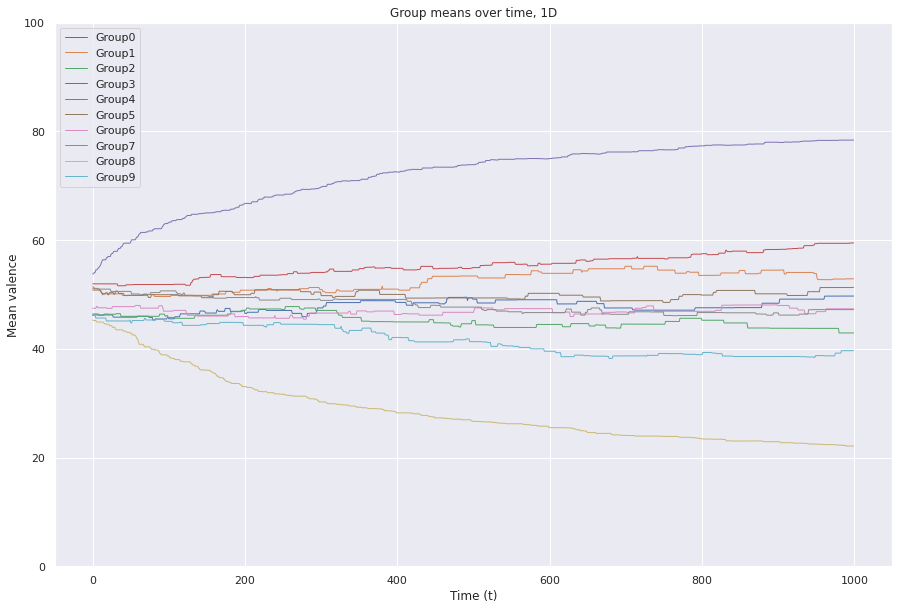

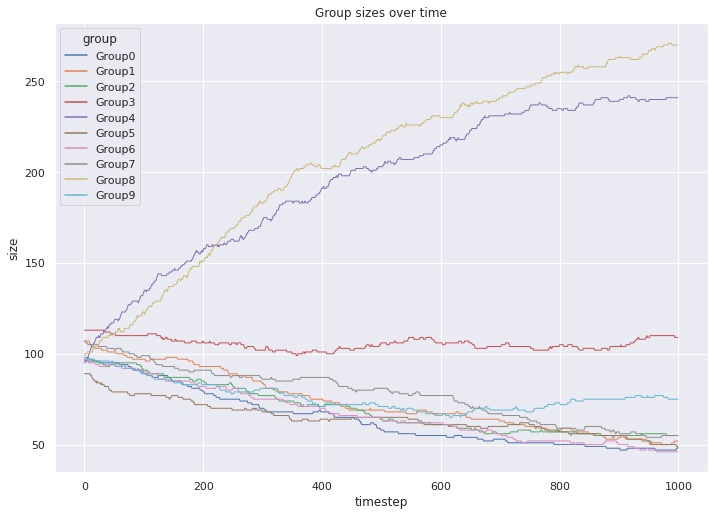

In [7]:
testSim = GroupshiftSim(groupshift_function = groupshiftSimpleMean,
                        indivchoice_function = oneNodeOpenSwitch)

num_nodes = 1000
num_groups = 10
timesteps = 1000

testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

In [ ]:
testSim.plotTimelineMeans()
testSim.plotTimelineSizes()

# Running

In [ ]:
#Recalculate means LEGACY VERSION
def meanRecalc(netw, groupname, resettype, s=3):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    netw.nodes[groupname]['mean'] = thismean
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random. 
      netw.nodes[groupname]['mean'] = np.random.randint(0,255,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

## Model 1 Baseline

Basic setup. Agents have value, they change groups, groups update means. 

In [ ]:
def model1(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 2 Including error

Inherited from model 1, but agent slightly changes randomly at each change. 

In [ ]:
def model2(num_nodes,num_groups,timesteps, e, plots=False,resettype='zero', s=3):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)

    #Add randomly noise to agent's value
    g.nodes[thisnode]['valence'] = [clamp(np.random.normal(g.nodes[thisnode]['valence'][x],e),0,255) for x in range(s)]

  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 3 Latitude of acceptability

Limiting individual's capacity to choose groups based on their current group

In [ ]:
def model3(num_nodes,num_groups,timesteps, k,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances between each group
    currentgroup = list(g.neighbors(thisnode))[0]
    #Get the k nearest groups
    gdists = {}
    for i in thesemeans:
      gdists[i] = np.linalg.norm(thesemeans[i] - g.nodes[currentgroup]['mean'])
    #Get the groupS (MULTIPLE!) within the latitude of acceptability
    mingroups = sorted(gdists, key=gdists.get)[0:k]

    #Calculate distances against the individual
    dists = {}
    for i in mingroups:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 4 Simple dictator

In [ ]:
def model4(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[0]['valence']) #Calculated against the preference of a single node
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 5 Modifier: Central Media

In [ ]:
def model5(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      d = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
      groupnum = int(''.join(map(lambda c: c if c in '0123456789' else '', i))) #Modify the distances
      dists[i] = d*(float(groupnum+1)/num_groups)
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 6 Group dictator

In [ ]:
def model6(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Randomly select member of group 0
    dictatornode = np.random.choice( list(g.neighbors('Group0')) )
    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[dictatornode]['valence']) #Calculated against the preference of a single node
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 7 Change rates 1

At every timestep, randomly update the opinion of a single agent. Change group update function to update by rate toward mean. 

In [ ]:
def meanAdjust(netw, groupname, rate, resettype, s=3):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    oldmean = netw.nodes[groupname]['mean']
    truemean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    if oldmean < truemean: 
      netw.nodes[groupname]['mean'] = oldmean + rate
    elif oldmean > truemean:
      netw.nodes[groupname]['mean'] = oldmean - rate
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random. 
      netw.nodes[groupname]['mean'] = np.random.randint(0,255,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

In [ ]:
def model7(num_nodes,num_groups,timesteps,eta, theta, plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Instantiate group means
  for i in grouplist:
    meanRecalc(g,i,resettype,s=s)

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanAdjust(g,i,theta,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)

    #Randomly update one agent's opinion
    shiftnode = np.random.choice(range(num_nodes))
    oldvalence = g.nodes[shiftnode]['valence']
    groupmean = g.nodes[list(g.neighbors(thisnode))[0]]['mean']
    if oldvalence < groupmean:
      g.nodes[shiftnode]['valence'] = oldvalence + eta
    elif oldvalence > groupmean:
      g.nodes[shiftnode]['valence'] = oldvalence - eta
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

### Model 1

In [ ]:
num_nodes = 2500
num_groups = 100
timesteps = 10000
g, otherdata = model1(num_nodes,num_groups,timesteps, resettype='rand', s=1)

100%|██████████| 10000/10000 [02:05<00:00, 79.77it/s]


### Model 2

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 20000
g, otherdata = model2(num_nodes,num_groups,timesteps, e=50, resettype='rand', s=1)

100%|██████████| 20000/20000 [01:17<00:00, 258.09it/s]


In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 10000
varying_es = [1,50]

for e in varying_es:
  print("e = %i"%e)
  g, otherdata = model2(num_nodes,num_groups,timesteps, e, resettype='rand', s=1)

  #Grabbing and plotting means over time
  grouplist = ['Group%i'%i for i in range(num_groups)]
  meansdata = {i:[] for i in grouplist}
  for m in otherdata['means']:
    for group in grouplist:
      meansdata[group].append(m[group])

  #Plotting means for 1D
  plt.figure(figsize=(15,10))
  for group in grouplist:
    thisthing = np.array(meansdata[group]).T
    plt.plot(thisthing[0], linewidth=5, label=group)

  plt.title("Group means over time, 1D")
  plt.xlabel("Time (t)")
  plt.ylabel("Mean valence")
  plt.legend()
  plt.savefig("Model 2 Means e=%i.png"%e)
  plt.clf()

    #Constructing a tidy dataframe
  grouplist = ['Group%i'%i for i in range(num_groups)]
  to_dataframe = {'group': [], 'timestep': [], 'size': []}
  for i, m in enumerate(otherdata['sizes']):
    for group in grouplist:
      to_dataframe['group'].append(group)
      to_dataframe['timestep'].append(i)
      to_dataframe['size'].append(m[group])
    
  modeldf = pd.DataFrame(to_dataframe)

  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.lineplot(x='timestep', y='size', hue='group', data = modeldf, linewidth=3).set(title="Group sizes over time")
  plt.savefig("Model 2 Sizes e=%i.png"%e)
  plt.clf()

e = 1


100%|██████████| 10000/10000 [00:45<00:00, 221.00it/s]


e = 50


100%|██████████| 10000/10000 [00:44<00:00, 226.03it/s]


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

### Model 3

In [ ]:
num_nodes = 5000
num_groups = 25
timesteps = 40000
g, otherdata = model3(num_nodes,num_groups,timesteps, k=4, resettype='rand', s=1)

100%|██████████| 40000/40000 [10:27<00:00, 63.73it/s]


## Model 4

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 40000
g, otherdata = model4(num_nodes,num_groups, timesteps)

100%|██████████| 40000/40000 [02:03<00:00, 323.71it/s]


## Model 5

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 15000
g, otherdata = model5(num_nodes,num_groups, timesteps)

100%|██████████| 15000/15000 [01:01<00:00, 242.70it/s]


## Model 6

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 40000
g, otherdata = model6(num_nodes,num_groups, timesteps)

100%|██████████| 40000/40000 [02:05<00:00, 319.25it/s]


## Model 7

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 40000
#Individual shifting parameter
eta = 1
#Group shifting parameter
theta = 5
g, otherdata = model7(num_nodes,num_groups,timesteps, eta, theta, s=1)

100%|██████████| 40000/40000 [02:33<00:00, 260.33it/s]


# Plots

### Plotting means

In [ ]:
#Grabbing and plotting means over time
grouplist = ['Group%i'%i for i in range(num_groups)]
meansdata = {i:[] for i in grouplist}
for m in otherdata['means']:
  for group in grouplist:
    meansdata[group].append(m[group])

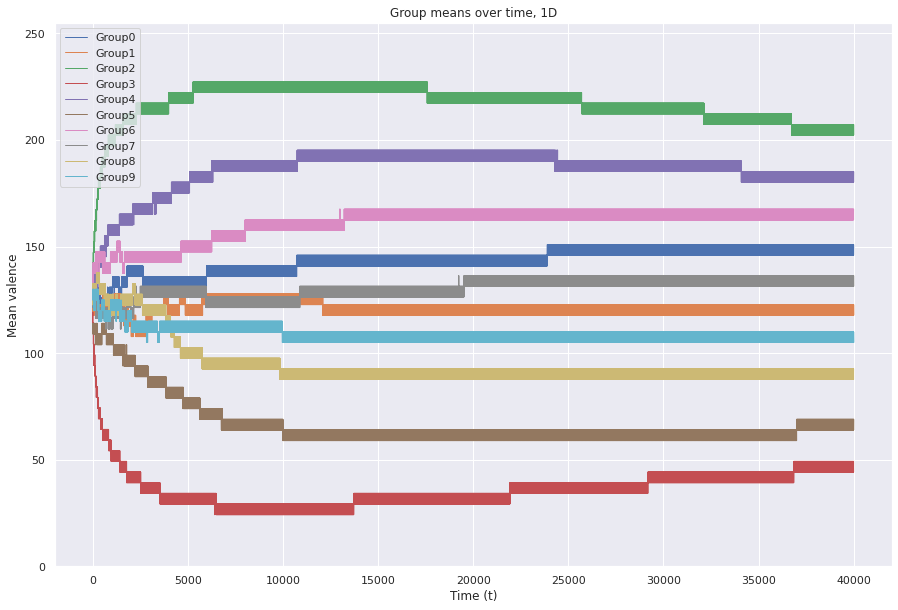

In [ ]:
#For 1D

plt.figure(figsize=(15,10))

for group in grouplist:
  thisthing = np.array(meansdata[group]).T
  plt.plot(thisthing[0], linewidth=1, label=group)

plt.title("Group means over time, 1D")
plt.xlabel("Time (t)")
plt.ylabel("Mean valence")
plt.ylim(0,255)
plt.legend()
#plt.savefig("Model 5 Means linear media.png")
plt.show()

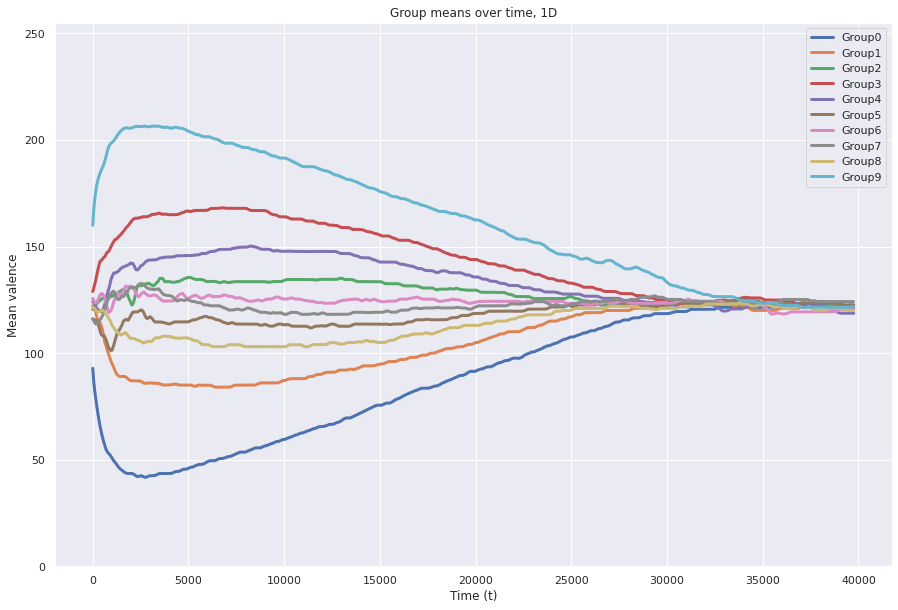

In [ ]:
#Plot running average

binsize = 250
plt.figure(figsize=(15,10))

for group in grouplist:
  thisthing = np.array(meansdata[group]).T
  plt.plot(moving_average(thisthing[0], binsize), linewidth=3, label=group)

plt.title("Group means over time, 1D")
plt.xlabel("Time (t)")
plt.ylabel("Mean valence")
plt.ylim(0,255)
plt.legend()
plt.show()

### Plotting group sizes

In [ ]:
#Constructing a tidy dataframe
grouplist = ['Group%i'%i for i in range(num_groups)]
to_dataframe = {'group': [], 'timestep': [], 'size': []}
for i, m in enumerate(otherdata['sizes']):
  for group in grouplist:
    to_dataframe['group'].append(group)
    to_dataframe['timestep'].append(i)
    to_dataframe['size'].append(m[group])
  
modeldf = pd.DataFrame(to_dataframe)

[Text(0.5, 1.0, 'Group sizes over time')]

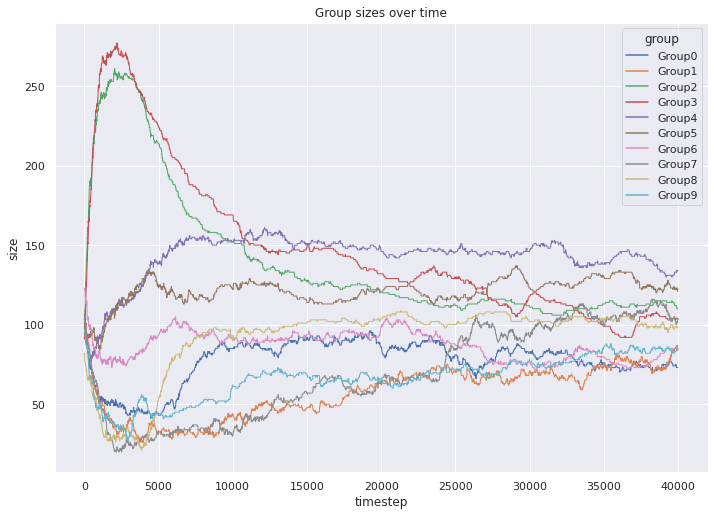

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='timestep', y='size', hue='group', data = modeldf, linewidth=1, legend=True).set(title="Group sizes over time")

## Plotting agent opinion distribution

Text(5.334999999999994, 0.5, 'Num agents')

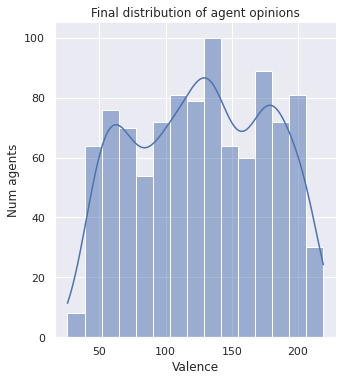

In [ ]:
#grouplist = ['Group%i'%i for i in range(num_groups)]
agent_valences = [x[0] for x in nx.get_node_attributes(g,'valence').values()]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(agent_valences, bins=15, kde=True).set(title='Final distribution of agent opinions')
plt.xlabel('Valence')
plt.ylabel('Num agents')